In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import product_finder
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

**Replace user/password with credentials for the cpernicus scihub**

In [3]:
# replace!
username = 'XXX'
password = 'XXX'

api = product_finder.instantiate_api(username, password)

In [4]:
products_gdf = product_finder.find_products(api, 'RCCR_working_areas/golfo_dulce_aoi.json', 
                                            start_date='20000101', end_date='20200415',
                                           processinglevel='Level-1C', max_cloudpercentage=100)

Searching products for geojson located at: RCCR_working_areas/golfo_dulce_aoi.json


Querying products: 100%|██████████| 439/439 [00:17<00:00, 24.88 products/s]


Found 439 products for Ãrea de trabajo RCCR/Golfo Dulce


/home/angela/anaconda3/envs/coral_datadownload/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [5]:
products_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 439 entries, 099239ba-401b-49f5-8c1e-08f917de07e7 to c731a39c-74a6-424a-9370-ac95faaef6ad
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   title                     439 non-null    object        
 1   link                      439 non-null    object        
 2   link_alternative          439 non-null    object        
 3   link_icon                 439 non-null    object        
 4   summary                   439 non-null    object        
 5   datatakesensingstart      419 non-null    datetime64[ns]
 6   beginposition             439 non-null    datetime64[ns]
 7   endposition               439 non-null    datetime64[ns]
 8   ingestiondate             439 non-null    datetime64[ns]
 9   orbitnumber               439 non-null    int64         
 10  relativeorbitnumber       439 non-null    int64         
 11  cloudcoverper

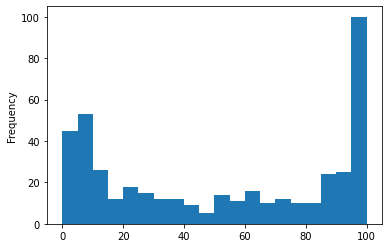

In [6]:
products_gdf['cloudcoverpercentage'].plot.hist(bins=20)

In [7]:
products_gdf['year'] = pd.DatetimeIndex(products_gdf['beginposition']).year
products_gdf['month'] = pd.DatetimeIndex(products_gdf['beginposition']).month

In [9]:
dataset = products_gdf[['year','month', 'cloudcoverpercentage']]

In [10]:
per_month = dataset.groupby('month')
#per_month['month'].agg(np.mean)
cc_permonth = per_month['cloudcoverpercentage'].agg(np.mean)
cc_permonth[1]
values = [m for m in cc_permonth]
values

[21.047965957446813,
 20.955191891891893,
 20.357755555555556,
 54.74946857142856,
 73.98222222222222,
 77.68478484848484,
 73.8040484848485,
 77.12997058823528,
 73.10368333333332,
 73.64537222222224,
 62.00930294117646,
 32.874005128205134]

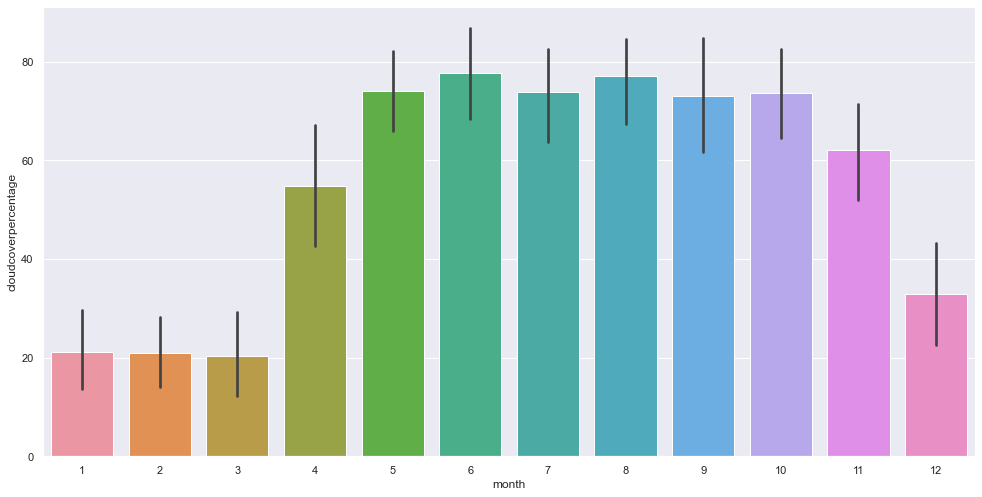

In [11]:
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(16.7,8.27)})
ax = sns.barplot(x="month", y="cloudcoverpercentage", data=dataset)

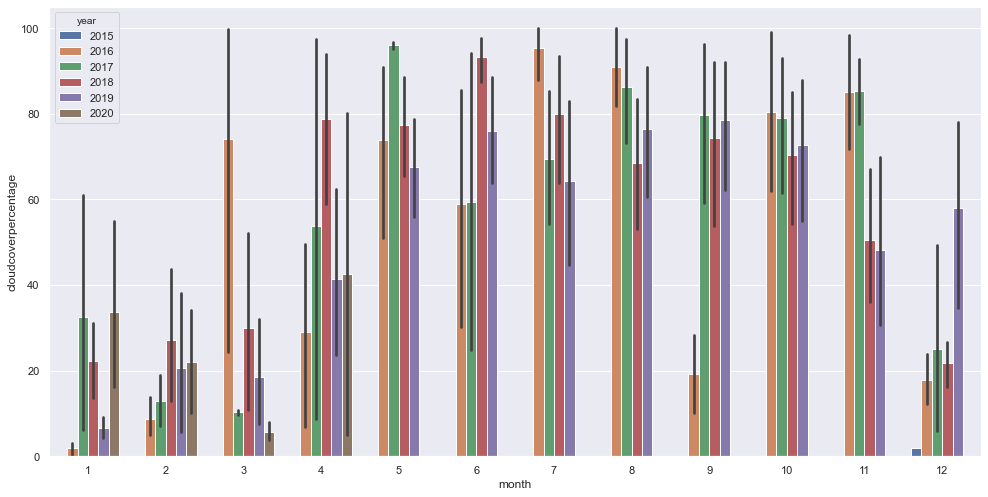

In [12]:
ax = sns.barplot(x="month", y="cloudcoverpercentage", hue="year",data=dataset)

In [17]:
#params = products_gdf.beginposition.map(lambda ts: (ts.strftime('%Y/%m/%d'), ts.hour+ts.minute/60.0))
#print(params.size)
#for index, value in params.items():
#    date, time = value
#    print(f"download files for date: {date}, time: {time}")
#    ancillary_get(date=date,
#              lon=-83.35765476893776, lat=8.604487829743483,
#              ftime=time,
#              local_dir='data/MET')
#eouser@ds3u:/eodata/Sentinel-2/MSI/L1C/2020/03/01$ 
def get_product_path(title, timestamp, root='/eodata/Sentinel-2/MSI/L1C'):
    path = root +'/' + timestamp.strftime('%Y/%m/%d') + '/' + title + '.SAFE' 
    return path

### Extract Product Location
1. Generates the absolute path for the products for the mounted ``/eodata`` of the vm on cloudferro.
2. Uses the sentinel api to query products of the Golfo Dulce area with a cloud percentage less than 20%.
3. The result is written as a csv in the ``data`` folder.

In [7]:
products_20 = product_finder.find_products(api, 'RCCR_working_areas/golfo_dulce_aoi.json', 
                                            start_date='20000101', end_date='20200415',
                                           processinglevel='Level-1C', max_cloudpercentage=30)


#df['product_path'] = df.apply(lambda x: get_sublist(x.col_1, x.col_2), axis=1)

Searching products for geojson located at: RCCR_working_areas/golfo_dulce_aoi.json


Querying products: 100%|██████████| 136/136 [00:01<00:00, 96.01 products/s]

Found 136 products for Ãrea de trabajo RCCR/Golfo Dulce


In [22]:
products_20['eodata_path'] = products_20.apply(lambda x: get_product_path(x.title, x.beginposition), axis=1)

products_20.eodata_path.to_csv('data/eodata_paths.csv', index=False, header=None)

### Downlaod product with given title
Download example product to process with acolite:
S2A_MSIL1C_20200321T160511_N0209_R054_T17PKK_20200321T205449

In [17]:
product = products_gdf.loc[products_gdf['title'] == 'S2A_MSIL1C_20200321T160511_N0209_R054_T17PKK_20200321T205449']

uuid = product['uuid'][0]
target_dir = 'data'
prod_download = api.download(uuid, directory_path=target_dir)
filename = prod_download['title']+ '.zip'
filepath = os.path.join(target_dir, filename)
with zipfile.ZipFile(filepath,"r") as zip_ref:
    zip_ref.extractall(target_dir)

In [ ]:
#TODO
#S2A_MSIL1C_20200111T160511_N0208_R054_T17PKK_20200111T192620
#S2A_MSIL1C_20200131T160501_N0208_R054_T17PKK_20200131T192646
#S2B_MSIL1C_20200116T160509_N0208_R054_T17PKK_20200116T190924